<a href="https://colab.research.google.com/github/cooocoooc/machine-learning-project/blob/main/neural%20network/colab/ViT-200.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vision Transformers

Reference: [YouTube](https://www.youtube.com/watch?v=j3VNqtJUoz0)

## Setup

In [1]:
!pip install einops

## Image Patching

Dataset OxfordIIITPet
    Number of datapoints: 3680
    Root location: .


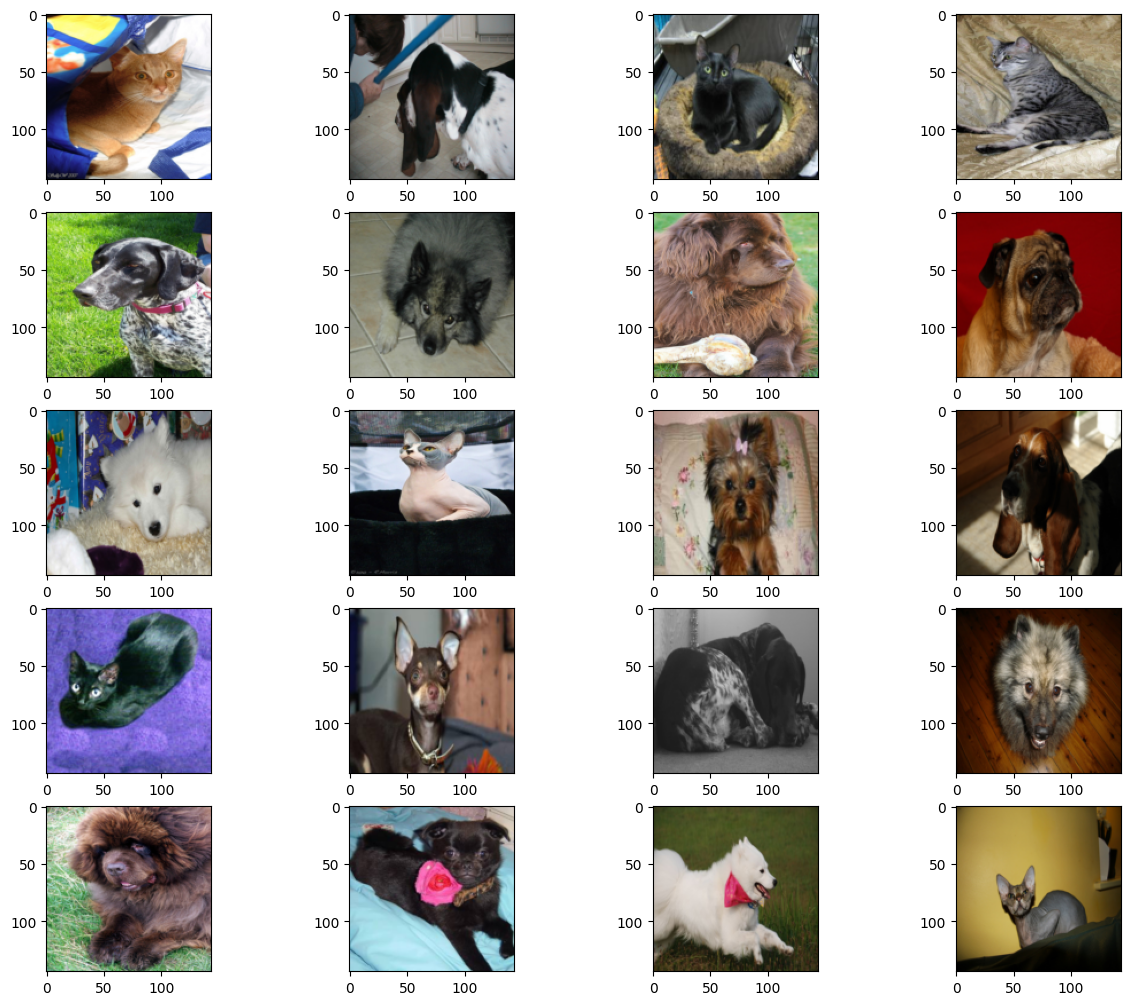

In [15]:
import torch
from torchvision.datasets import OxfordIIITPet
import matplotlib.pyplot as plt
from random import random
from torchvision.transforms import Resize, ToTensor
from torchvision.transforms.functional import to_pil_image

to_tensor = [Resize((144, 144)), ToTensor()]

class Compose(object):
  def __init__(self, transforms): # Changed __int to __init__
    self.transforms = transforms

  def __call__(self, image, target):
    for t in self.transforms:
      image = t(image)
    return image, target

def show_images(images, num_samples = 20, cols=4):
  """ plots some samples from the dataset """
  plt.figure(figsize=(15, 15))
  idx = int(len(images)/ num_samples)
  print(images)
  for i, img in enumerate(images):
    if i % idx == 0:
      plt.subplot(int(num_samples/cols) + 1, cols, int(i/idx) + 1)
      plt.imshow(to_pil_image(img[0]))

dataset = OxfordIIITPet(root=".", download=True, transforms=Compose(to_tensor))
show_images(dataset)

## Patch images

In [16]:
from torch import nn
from einops.layers.torch import Rearrange
from torch import Tensor

class PatchEmbedding(nn.Module):
  def __init__(self, in_channels = 3, patch_size = 8, emb_size = 128):
    self.patch_size = patch_size
    super().__init__()
    self.projection = nn.Sequential(
        Rearrange("b c (h p1)(w p2) -> b(h w)(p1 p2 c)", p1=patch_size, p2=patch_size),
        nn.Linear(patch_size * patch_size * in_channels, emb_size)
    )

  def forward(self, x: Tensor) -> Tensor:
    x = self.projection(x)
    return x
sample_datapoint = torch.unsqueeze(dataset[0][0], 0)
print('initial shape:', sample_datapoint.shape)
embedding = PatchEmbedding()(sample_datapoint)
print('Patches shape:', embedding.shape)

initial shape: torch.Size([1, 3, 144, 144])
Patches shape: torch.Size([1, 324, 128])


## Model

In [17]:
from einops import rearrange

class Attention(nn.Module):
  def __init__(self, dim, n_heads, dropout):
    super().__init__()
    self.n_heads = n_heads
    self.att = torch.nn.MultiheadAttention(embed_dim=dim,
                                           num_heads=n_heads,
                                           dropout=dropout)
    self.q = torch.nn.Linear(dim, dim)
    self.k = torch.nn.Linear(dim, dim)
    self.v = torch.nn.Linear(dim, dim)

  def forward(self, x):
    q = self.q(x)
    k = self.k(x)
    v = self.v(x)
    attn_output, attn_output_weights = self.att(x, x, x)
    return attn_output

In [18]:
Attention(dim=128, n_heads=4, dropout=0.)(torch.ones((1, 5, 128))).shape

torch.Size([1, 5, 128])

In [19]:
class PreNorm(nn.Module):
  def __init__(self, dim, fn):
    super().__init__()
    self.norm = nn.LayerNorm(dim)
    self.fn = fn

  def forward(self, x, **kwargs):
    return self.fn(self.norm(x), **kwargs)

In [20]:
norm = PreNorm(128, Attention(dim=128, n_heads=4, dropout=0))
norm(torch.ones((1, 5, 128))).shape


torch.Size([1, 5, 128])

In [21]:
class FeedForward(nn.Sequential):
  def __init__(self, dim, hidden_dim, dropout = 0):
    super().__init__(
        nn.Linear(dim, hidden_dim),
        nn.GELU(),
        nn.Dropout(dropout),
        nn.Linear(hidden_dim, dim),
        nn.Dropout(dropout)
    )
ff = FeedForward(dim = 128, hidden_dim = 256)
ff(torch.ones((1, 5, 128))).shape

torch.Size([1, 5, 128])

In [22]:
class ResidualAdd(nn.Module):
  def __init__(self, fn):
    super().__init__()
    self.fn = fn

  def forward(self, x, **kwargs):
    res = x
    x = self.fn(x, **kwargs)
    x += res
    return x

In [23]:
residual_att = ResidualAdd(Attention(dim=128, n_heads = 4, dropout = 0))
residual_att(torch.ones((1, 5, 128))).shape

torch.Size([1, 5, 128])

In [24]:
from einops import repeat

class ViT(nn.Module):
  def __init__(self, ch=3, img_size=144, patch_size=8, emb_dim=32,
               n_layers=4, out_dim=37, dropout=0.1, heads=2):
    super(ViT, self).__init__()

    # Attributes
    self.channels = ch
    self.height = img_size
    self.width = img_size
    self.patch_size = patch_size
    self.n_layers = n_layers

    # patching
    self.patch_embedding = PatchEmbedding(in_channels=ch,
                                          patch_size=patch_size,
                                          emb_size = emb_dim)

    # learnable params
    num_patchs = (img_size // patch_size) ** 2
    self.pos_embedding = nn.Parameter(
        torch.randn(1, num_patchs + 1, emb_dim))
    self.cls_token = nn.Parameter(torch.rand(1, 1, emb_dim))

    # transformer encoder
    self.layers = nn.ModuleList([]) # Changed Modulelist to ModuleList
    for _ in range(n_layers):
      transformer_block = nn.Sequential(
          ResidualAdd(PreNorm(emb_dim, Attention(emb_dim, n_heads = heads, dropout = dropout))),
          ResidualAdd(PreNorm(emb_dim, FeedForward(emb_dim, emb_dim, dropout = dropout))))
      self.layers.append(transformer_block)

    # classification head
    self.head = nn.Sequential(nn.LayerNorm(emb_dim), nn.Linear(emb_dim, out_dim)) # Changed nn.linear to nn.Linear

  def forward(self, img):
    # get patch embedding vectors
    x = self.patch_embedding(img)
    b, n, _ = x.shape

    # add cls token to inputs
    cls_token = repeat(self.cls_token,'1 1 d -> b 1 d', b = b)
    x = torch.cat((cls_token, x), dim=1)
    x += self.pos_embedding[:,:(n + 1)]

    # transformer layers
    for i in range(self.n_layers):
      x = self.layers[i](x)

    # output based on classification token
    return self.head(x[:, 0 , :])

model = ViT()
print(model)
model(torch.ones((1, 3, 144, 144)))

ViT(
  (patch_embedding): PatchEmbedding(
    (projection): Sequential(
      (0): Rearrange('b c (h p1)(w p2) -> b(h w)(p1 p2 c)', p1=8, p2=8)
      (1): Linear(in_features=192, out_features=32, bias=True)
    )
  )
  (layers): ModuleList(
    (0-3): 4 x Sequential(
      (0): ResidualAdd(
        (fn): PreNorm(
          (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (fn): Attention(
            (att): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
            )
            (q): Linear(in_features=32, out_features=32, bias=True)
            (k): Linear(in_features=32, out_features=32, bias=True)
            (v): Linear(in_features=32, out_features=32, bias=True)
          )
        )
      )
      (1): ResidualAdd(
        (fn): PreNorm(
          (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (fn): FeedForward(
            (0): Linear(in_features=32, out_feature

tensor([[-0.8910, -0.6669, -0.9063,  0.0978, -0.5539,  1.1290,  0.8307,  0.1010,
          0.5222,  0.4332,  0.6670,  0.5204,  0.5972,  1.2989,  0.5270,  0.7143,
          0.4427,  0.1638, -0.5206, -1.1078,  0.1791,  0.6124,  0.2533,  0.1405,
         -0.3424, -0.6392, -0.2877,  0.2032, -0.8916, -0.0696,  1.0343, -0.5501,
          0.5932,  0.2897, -0.5803,  0.8645,  1.0448]],
       grad_fn=<AddmmBackward0>)

## Training

In [25]:
from torch.utils.data import DataLoader
from torch.utils.data import random_split

train_split = int(0.8 * len(dataset))
train, test = random_split(dataset, [train_split, len(dataset) - train_split])

train_dataloader = DataLoader(train, batch_size = 32, shuffle = True)
test_dataloader = DataLoader(test, batch_size = 32, shuffle = True)


In [26]:
import torch.optim as optim
import numpy as np

device = "cuda"
modle = ViT().to(device)
optimizer = optim.AdamW(modle.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

for epoch in range(200):
  epoch_losses = []
  modle.train()
  for step, (inptus, lables) in enumerate(train_dataloader):
    inptus, lables = inptus.to(device), lables.to(device)
    optimizer.zero_grad()
    outputs = modle(inptus)
    loss = criterion(outputs, lables)
    loss.backward()
    optimizer.step()
    epoch_losses.append(loss.item())
  if epoch % 5 == 0:
    print(f">>> Epoch{epoch} train loss: ", np.mean(epoch_losses))
    epoch_losses = []
    # something was strange when using this
    # modle.eval()
    for step, (inputs, labels) in enumerate(test_dataloader):
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = modle(inputs)
      loss = criterion(outputs, labels)
      epoch_losses.append(loss.item())
    print(f">>> Epoch {epoch} test loss: ", np.mean(epoch_losses))

>>> Epoch0 train loss:  3.649051575557045
>>> Epoch 0 test loss:  3.6230427907860796
>>> Epoch5 train loss:  3.622711420059204
>>> Epoch 5 test loss:  3.626636670983356
>>> Epoch10 train loss:  3.6193599260371663
>>> Epoch 10 test loss:  3.6174859378648843
>>> Epoch15 train loss:  3.6201403270597043
>>> Epoch 15 test loss:  3.6241539042928945
>>> Epoch20 train loss:  3.6193594077359075
>>> Epoch 20 test loss:  3.6214426911395527
>>> Epoch25 train loss:  3.617410333260246
>>> Epoch 25 test loss:  3.6191100348596987
>>> Epoch30 train loss:  3.617672624795333
>>> Epoch 30 test loss:  3.6196844474129053
>>> Epoch35 train loss:  3.616058647632599
>>> Epoch 35 test loss:  3.617981952169667
>>> Epoch40 train loss:  3.615492053653883
>>> Epoch 40 test loss:  3.617093853328539
>>> Epoch45 train loss:  3.6151160312735517
>>> Epoch 45 test loss:  3.620842985484911
>>> Epoch50 train loss:  3.6151706083961157
>>> Epoch 50 test loss:  3.618623049362846
>>> Epoch55 train loss:  3.6155961726022805
>>>

In [27]:
inputs, labels = next(iter(test_dataloader))
inputs, labels = inputs.to(device), labels.to(device)
outputs = modle(inputs)

print("Predicted classes", outputs.argmax(-1))
print("Actual classes", labels)

Predicted classes tensor([30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
        30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30],
       device='cuda:0')
Actual classes tensor([24, 26, 12,  3,  6, 13, 10,  7, 32,  0, 19, 28, 25, 11, 18,  2, 35, 22,
        29, 35,  9, 16,  3, 14, 28, 12, 25,  5, 27, 35, 13, 11],
       device='cuda:0')
